In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/FruitinAmazon.zip"

Archive:  /content/drive/MyDrive/FruitinAmazon.zip
  inflating: FruitinAmazon/test/cupuacu/download (5).jpeg  
  inflating: FruitinAmazon/test/acai/images (2).jpeg  
  inflating: FruitinAmazon/test/cupuacu/download (3).jpeg  
  inflating: FruitinAmazon/test/acai/images (16).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (2).jpeg  
  inflating: FruitinAmazon/train/pupunha/images (1).jpeg  
  inflating: FruitinAmazon/test/cupuacu/download (2).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (1).jpeg  
  inflating: FruitinAmazon/train/acai/images (3).jpeg  
  inflating: FruitinAmazon/train/acai/images (4).jpeg  
  inflating: FruitinAmazon/test/graviola/download (1).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (11).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (4).jpeg  
  inflating: FruitinAmazon/train/acai/images (11).jpeg  
  inflating: FruitinAmazon/test/tucuma/download (1).jpeg  
  inflating: FruitinAmazon/test/acai/images.jpeg  
  inflating: Fruit

In [ ]:
!pip install keras tensorflow

In [ ]:
import tensorflow as tf
print(tf.keras.__version__)

3.8.0


In [ ]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf

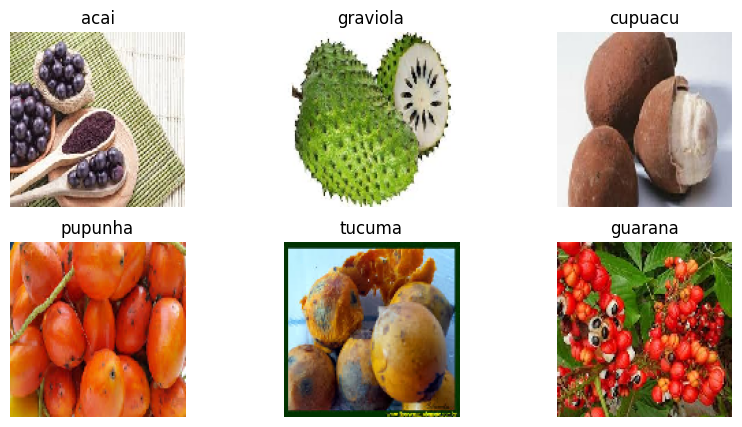

No corrupted images found.


In [ ]:
def load_and_visualize_images(train_dir):
    class_names = os.listdir(train_dir)
    selected_images = []

    for class_name in class_names:
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path):  # Ensure it's a directory
            image_name = random.choice(os.listdir(class_path))
            image_path = os.path.join(class_path, image_name)
            selected_images.append((image_path, class_name))

    fig, axes = plt.subplots(2, len(selected_images)//2, figsize=(10, 5))
    axes = axes.flatten()
    for ax, (img_path, label) in zip(axes, selected_images):
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.show()

# Task 1.2: Check for Corrupted Images
def check_corrupted_images(train_dir):
    corrupted_images = []
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path):  # Ensure it's a directory
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = tf.keras.preprocessing.image.load_img(img_path)
                except (IOError, SyntaxError):
                    corrupted_images.append(img_path)
                    os.remove(img_path)
                    print(f"Removed corrupted image: {img_path}")

    if not corrupted_images:
        print("No corrupted images found.")

# Example Usage
train_dir = "FruitinAmazon/train"
load_and_visualize_images(train_dir)
check_corrupted_images(train_dir)

In [ ]:
import tensorflow as tf

def load_and_preprocess_data(train_dir, img_height, img_width, batch_size, validation_split):
    rescale = tf.keras.layers.Rescaling(1./255)

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',
        image_size=(img_height, img_width),
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=True,
        validation_split=validation_split,
        subset='training',
        seed=123
    )

    train_ds = train_ds.map(lambda x, y: (rescale(x), y))

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',
        image_size=(img_height, img_width),
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=False,
        validation_split=validation_split,
        subset='validation',
        seed=123
    )

    val_ds = val_ds.map(lambda x, y: (rescale(x), y))

    return train_ds, val_ds

# Example usage
img_height = 128
img_width = 128
batch_size = 32
validation_split = 0.2
train_ds, val_ds = load_and_preprocess_data(train_dir, img_height, img_width, batch_size, validation_split)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [ ]:
from tensorflow.keras import layers, models

def create_cnn_model(num_classes, input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Example usage
num_classes = len(os.listdir(train_dir))  # Adjust based on your dataset
input_shape = (img_height, img_width, 3)
model = create_cnn_model(num_classes, input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=10, restore_best_weights=True)
]

history = model.fit(train_ds, epochs=250, validation_data=val_ds, callbacks=callbacks)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.1701 - loss: 3.4309

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 792ms/step - accuracy: 0.1693 - loss: 3.6062 - val_accuracy: 0.1667 - val_loss: 1.3264
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 756ms/step - accuracy: 0.2713 - loss: 1.9497 - val_accuracy: 0.1111 - val_loss: 1.7110
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - accuracy: 0.4310 - loss: 1.6986 - val_accuracy: 0.0000e+00 - val_loss: 1.8191
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - accuracy: 0.4792 - loss: 1.5673 - val_accuracy: 0.0000e+00 - val_loss: 2.0102
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - accuracy: 0.5334 - loss: 1.4238 - val_accuracy: 0.1667 - val_loss: 1.7108
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.4641 - loss: 1.3257

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 559ms/step - accuracy: 0.4696 - loss: 1.3167 - val_accuracy: 0.6111 - val_loss: 1.2679
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.6811 - loss: 1.0521

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 559ms/step - accuracy: 0.6740 - loss: 1.0560 - val_accuracy: 0.5000 - val_loss: 1.2595
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.7801 - loss: 0.8862

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 553ms/step - accuracy: 0.7795 - loss: 0.8791 - val_accuracy: 0.7222 - val_loss: 0.9097
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.8808 - loss: 0.5693

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 872ms/step - accuracy: 0.8759 - loss: 0.5800 - val_accuracy: 0.8889 - val_loss: 0.5406
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 737ms/step - accuracy: 0.9488 - loss: 0.4168 - val_accuracy: 0.7222 - val_loss: 0.9043
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 528ms/step - accuracy: 0.9705 - loss: 0.3329 - val_accuracy: 0.7778 - val_loss: 0.6057
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.9190 - loss: 0.3108

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9253 - loss: 0.2989 - val_accuracy: 0.8333 - val_loss: 0.3526
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 903ms/step - accuracy: 0.9674 - loss: 0.1863 - val_accuracy: 0.8333 - val_loss: 0.4513
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 1.0000 - loss: 0.1171 - val_accuracy: 0.8333 - val_loss: 0.5605
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9797 - loss: 0.0680

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 571ms/step - accuracy: 0.9813 - loss: 0.0680 - val_accuracy: 0.8889 - val_loss: 0.3215
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 1.0000 - loss: 0.0450

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 1.0000 - loss: 0.0447 - val_accuracy: 0.9444 - val_loss: 0.1418
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - accuracy: 0.9783 - loss: 0.0609 - val_accuracy: 0.9444 - val_loss: 0.1760
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 784ms/step - accuracy: 1.0000 - loss: 0.0144 - val_accuracy: 0.8333 - val_loss: 0.5552
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 740ms/step - accuracy: 1.0000 - loss: 0.0198 - val_accuracy: 0.8333 - val_loss: 0.4579
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.8333 - val_loss: 0.4004
Epoch 21/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 0.8333 - val_loss: 0.3569
Epoch 22/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 481ms/step - accuracy: 1.0000 - loss: 0.0081 - val_accuracy: 0.8889 - val_loss: 0.2859
Epoch 23/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.8889 - val_loss:

In [ ]:
import tensorflow as tf

# Define the rescale layer
rescale = tf.keras.layers.Rescaling(1./255)

# Load and preprocess the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'FruitinAmazon/test',
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False
)

# Apply the normalization (Rescaling) to the test dataset
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")


Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.6667 - loss: 0.9180
Test accuracy: 0.6667


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

print(classification_report(true_labels, predicted_labels, target_names=os.listdir(train_dir)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
              precision    recall  f1-score   support

        acai       0.67      0.80      0.73         5
    graviola       0.67      0.80      0.73         5
     cupuacu       0.83      1.00      0.91         5
     pupunha       0.00      0.00      0.00         5
      tucuma       0.67      0.80      0.73         5
     guarana       0.50      0.60      0.55         5

    accuracy                           0.67        30
   macro avg       0.56      0.67      0.61        30
weighted avg       0.56      0.67      0.61        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


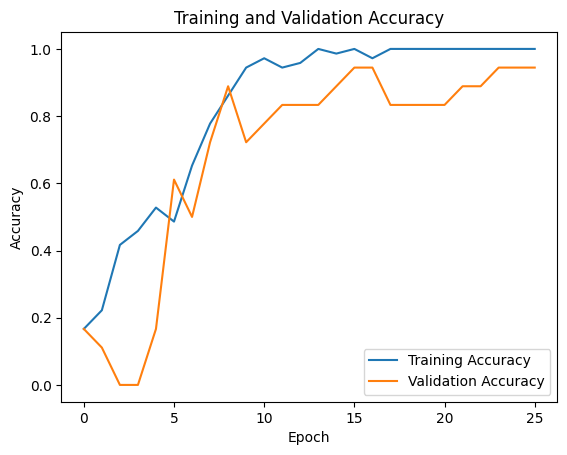

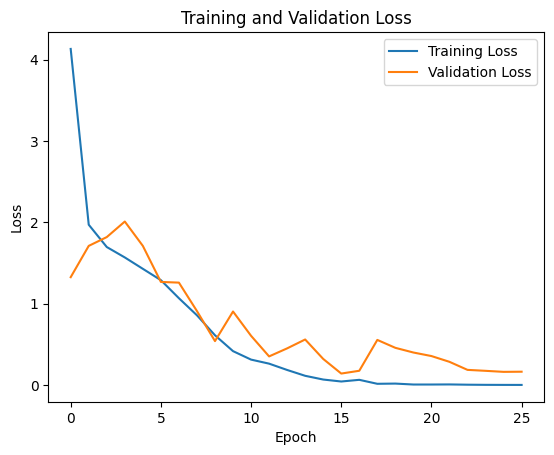

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras import layers, models, regularizers, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
def create_cnn_model(num_classes, input_shape):
    model = models.Sequential([
        Input(shape=input_shape),  # Fix: Use Input layer explicitly

        layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dropout(0.5),  # Dropout to reduce overfitting
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model